In [1]:
using Unfold
using PyMNE # MNE is a python library for EEG data analysis
using AlgebraOfGraphics # plotting Grammar of Graphics
using CSV
using DataFrames
using StatsBase # mean/std
using FileIO # loading data
using JLD2 # loading data
using StatsModels # UnfoldFit
using CairoMakie # Plotting Backend (SVGs/PNGs)
using Printf # interpolate strings
using DataFramesMeta # @subset etc. working with DataFrames
using StatsPlots
using Pipe
using UnfoldMakie
using TopoPlots
using ColorSchemes
#using GLMakie
using Query

In [2]:
using GLMakie

In [3]:
begin # load  one single-subject dataset
	
	# once artifacts are working, we could ship it. But for now you have to download it and 
 #p =joinpath(pathof(UnfoldMakie),"artifacts","sub002_ses-N180_task-N180_eeg.set")
	    
	p = "../../../../store/users/ehinger/projects/unfoldjl_dev/dev/UnfoldMakie/artifact/sub-002_ses-N170_task-N170_eeg.set"
    raw = PyMNE.io.read_raw_eeglab(p,preload=false)
end;

In [4]:
begin # load unfold-fitted dataset of all subjects
	# takes ~25s to load because it is quite large :)
	p_all = "../../../../store/users/ehinger/projects/unfoldjl_dev/data/erpcore-N170.jld2"
	presaved_data = load(p_all)
	dat_e = presaved_data["data_e_all"].* 1e6
	evt_e = presaved_data["df_e_all"]
end;

In [215]:
evt_e

In [6]:
begin
	# times vector (from-to)
	times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)

	# get standard errors
	se_solver =(x,y)->Unfold.solver_default(x,y,stderror=true)
	# define effect-coding
	contrasts= Dict(:category => EffectsCoding(), :condition => EffectsCoding())
	
	analysis_formula = @formula 0 ~ 1 + category * condition
	
	results_allSubjects = DataFrame()
	
	for sub ∈ unique(evt_e.subject)

		# select events of one subject
	    sIx = evt_e.subject .== sub

		# fit Unfold-Model
		# declaring global so we can access the variable outside of this loop (local vs. global scope)
	    global mres = Unfold.fit(UnfoldModel, 
						analysis_formula, 
						evt_e[sIx,:], 
						dat_e[:,:,sIx], 
						times, 
						contrasts=contrasts,
						solver=se_solver);

		# make results of one subject available
		global results_onesubject = coeftable(mres);

		# concatenate results of all subjects
	    results_onesubject[!,:subject] .= sub
	    append!(results_allSubjects,results_onesubject);
	    
	end;
	
end;

In [214]:
results_onesubject

In [6]:
Makie.inline!(true)
CairoMakie.activate!(type="svg")

# 1. Lineplot

In [103]:
Dict(:category=>["face","car"],:condition=>["intact"])

Dict{Symbol, Vector{String}} with 2 entries:
  :condition => ["intact"]
  :category  => ["face", "car"]

In [33]:
using Unfold

res = effects(Dict(:category=>["face","car"],:condition=>["scrambled","intact"]), mres) # (design, model)
res = @subset(res, :channel .== 28)
plot_results(res);

### version 1

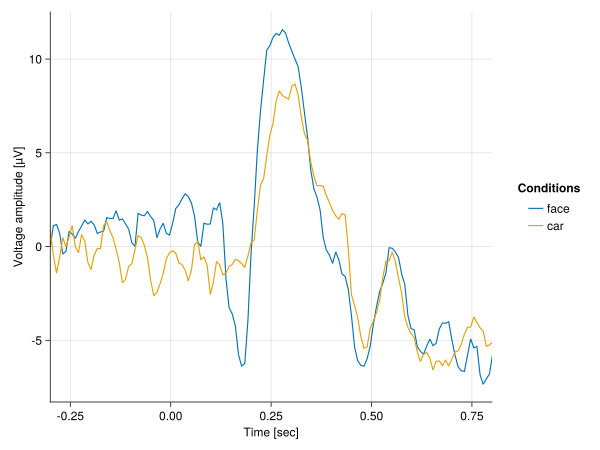

In [121]:
let 
    #=   data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .== 28) |>
        @transform(_, :channel = string.(:channel)) 
        data = filter(x -> x.coefname == "category: face" || x.coefname == "condition: scrambled" , data) =#
        
        res = effects(Dict(:category=>["face","car"], :condition=>["intact"]), mres)
        data = @pipe res |> 
            @subset(_, :channel .== 28)

        f = Figure()
        ax = f[1, 1] = Axis(f, #xticks = map(x -> round(x, digits = 2) , range(minimum(data.time), stop = maximum(data.time), length = 5)), 
            xlabel = "Time [sec]", ylabel = "Voltage amplitude [µV]")
        hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
        
        j = 0
        for i in unique(data[:, :category])
            #println(i)
            tmp = data[data[:, :category] .== i, :] 
            lines!(tmp.time, tmp.yhat, label = i)
            #j = j +1
            #lines!(tmp.time, tmp.estimate, label = string.(j))
        end 
        CairoMakie.xlims!(-0.3,0.8)
        f[1, 2] = Legend(f, ax, "Conditions", framevisible = false) 
        f
        #save("plots/plot1.svg", f)
end

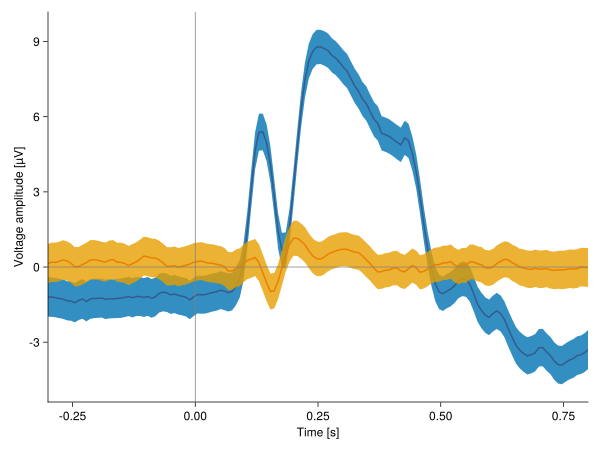

In [347]:
let
    data = filter(x -> x.coefname == "category: face" || x.coefname == "(Intercept)", results_allSubjects) 
    data.coefname = replace(data.coefname, "category: face" => "face", "(Intercept)" => "car")
    data = @pipe data |> 
            @subset(_, :channel .== 28) |> 
            rename!(_, :coefname => :conditions) |>
            groupby(_, [:time, :conditions]) |> 
            @transform!(_, :estimate_mean = mean(:estimate), :stderror_mean = mean(:stderror))|> 
            @subset(_, :subject .== 1)  |> 
            select(_, Not([:basisname, :group, :channel, :subject, :estimate, :stderror]))
    
    f = Figure()
    ax = f[1, 1] = Axis(f,
            xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    
    for i in unique(data[:, :conditions])
            tmp = data[data[:, :conditions] .== i, :] 
            lines!(tmp.time, tmp.estimate_mean, label = i, linewidth = 2, color = :red)
            band!(tmp.time, tmp.estimate_mean-tmp.stderror_mean, tmp.estimate_mean+tmp.stderror_mean, 
            colormap=:viridis)
    end 
    
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    CairoMakie.xlims!(-0.3,0.8)
    #f[1, 2] = Legend(f, ax, "Conditions", framevisible = false) 
    hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
    hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots/plot1.svg", f)
end

In [8]:
attributes(Makie.Band)

MethodError: MethodError: no method matching attributes(::Type{Combined{Makie.band}})
Closest candidates are:
  attributes(!Matched::Attributes) at ~/.julia/packages/MakieCore/8YGMv/src/attributes.jl:33

In [276]:
data = filter(x -> x.coefname == "category: face" || x.coefname == "(Intercept)", results_allSubjects) 
data.coefname = replace(data.coefname, "category: face" => "face", "(Intercept)" => "car")
data = @pipe data |> 
            @subset(_, :channel .== 28) |> 
            rename!(_, :coefname => :conditions) |>
            groupby(_, [:time, :conditions]) |> 
            @transform!(_, :estimate_mean = mean(:estimate), :stderror_mean = mean(:stderror))|> 
            @subset(_, :subject .== 1)  |> 
            select(_, Not([:basisname, :group, :channel, :subject, :estimate, :stderror])) |>
            @subset(_, :time .< -0.28)  |> 
            groupby(_, :time) |>
            @transform!(_, :sum_cond = sum(:estimate_mean))

6×5 DataFrame
 Row │ conditions  time       estimate_mean  stderror_mean  sum_cond 
     │ String      Float64    Float64        Float64        Float64  
─────┼───────────────────────────────────────────────────────────────
   1 │ car         -0.3           -1.1951         0.78266   -1.05715
   2 │ car         -0.292187      -1.20257        0.786091  -1.00966
   3 │ car         -0.284375      -1.22232        0.785432  -1.03477
   4 │ face        -0.3            0.137958       0.78266   -1.05715
   5 │ face        -0.292187       0.192915       0.786091  -1.00966
   6 │ face        -0.284375       0.187552       0.785432  -1.03477

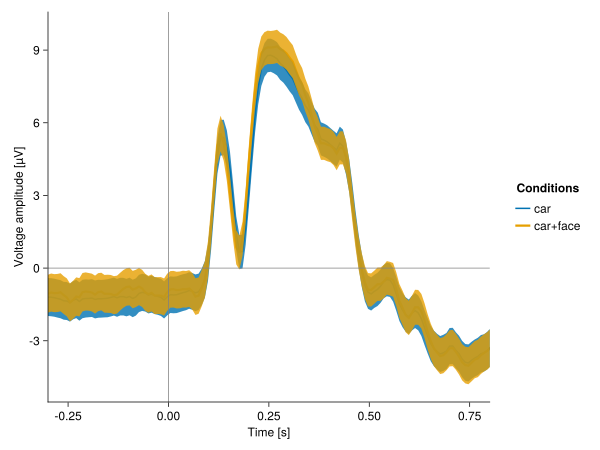

In [349]:
let
    data = filter(x -> x.coefname == "category: face" || x.coefname == "(Intercept)", results_allSubjects) 
    data.coefname = replace(data.coefname, "category: face" => "face", "(Intercept)" => "car")
    data = @pipe data |> 
            @subset(_, :channel .== 28) |> 
            rename!(_, :coefname => :conditions) |>
            groupby(_, [:time, :conditions]) |> 
            @transform!(_, :estimate_mean = mean(:estimate), :stderror_mean = mean(:stderror))|> 
            @subset(_, :subject .== 1)  |> 
            select(_, Not([:basisname, :group, :channel, :subject, :estimate, :stderror])) |>
            groupby(_, :time) |>
            @transform!(_, :sum_mean = sum(:estimate_mean))|> 
            @transform!(_, :sum_band = sum(:stderror_mean))|> 
            @subset(_, :conditions .== "car") 
    
    f = Figure()
    ax = f[1, 1] = Axis(f,
            xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    
    for i in unique(data[:, :conditions])
            tmp = data[data[:, :conditions] .== i, :] 
            lines!(tmp.time, tmp.estimate_mean, label = i, linewidth = 2)
            lines!(tmp.time, tmp.sum_mean, label = "car+face",  linewidth = 3)
            band!(tmp.time, tmp.estimate_mean-tmp.stderror_mean, tmp.estimate_mean+tmp.stderror_mean, colormap=:viridis)
            band!(tmp.time, tmp.sum_mean-tmp.stderror_mean, tmp.sum_mean+tmp.stderror_mean, colormap=:viridis)
    end 
    
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    CairoMakie.xlims!(-0.3,0.8)
    f[1, 2] = Legend(f, ax, "Conditions", framevisible = false) 
    hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
    hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots/plot1.svg", f)
end

- averaging
- hline and vline at zero
- drop the grid and legend
- sec -> s
- error bars accross paricipants (FaPra)

### version 2

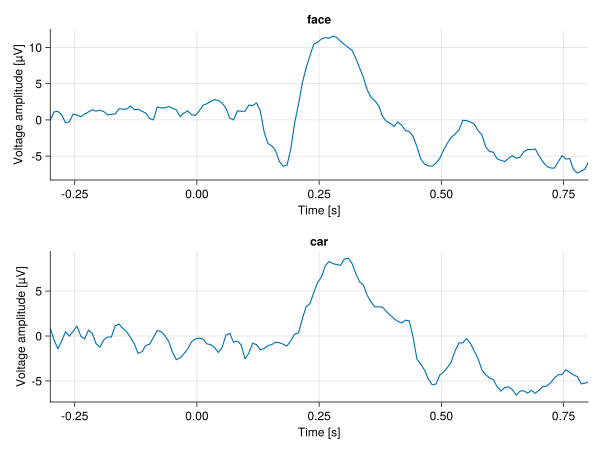

In [169]:
let 
     
    res = effects(Dict(:category=>["face","car"], :condition=>["intact"]), mres)
    data = @pipe res |> 
          @subset(_, :channel .== 28)
  
    f = Figure()
#=     ax = f[1, 1] = Axis(f, 
          xlabel = "Time [sec]", ylabel = "Voltage amplitude [µV]")
    hidespines!(ax, :t, :r) # delete unnecessary spines (lines) =#
        
    row = 0
    for i in unique(data[:, :category])
        row = row + 1
        ax = Axis(f[row, 1])
        tmp = data[data[:, :category] .== i, :] 
        lines!(tmp.time, tmp.yhat, label = i)
        CairoMakie.xlims!(-0.3,0.8)
        hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
        ax.title = i
        ax.xlabel = "Time [s]"
        ax.ylabel = "Voltage amplitude [µV]"

    end 

    
    f
    #save("plots/plot1.2.svg", f)
  end

- do we need an error bars here. If yes, should we take all channels?
- average of all channels + error bars

# 2. Butterfly plot

In [313]:
data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        #@subset(_, :channel .< 3) |>
        #@subset(_, :coefname .== ("category: face")) #|>
        @subset(_, :coefname .== ("(Intercept)")) |>
        #@transform(_, :channel = string.(:channel)) 
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected) |>
        @subset(_, :estimate_bsln_corrected .== maximum(:estimate_bsln_corrected))
data

1×7 DataFrame
 Row │ channel  coefname     estimate  stderror  time     subject  estimate_bs ⋯
     │ Int64    String       Float64   Float64   Float64  Int64    Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      32  (Intercept)    6030.7   8.73334    0.825       40              ⋯
                                                                1 column omitted

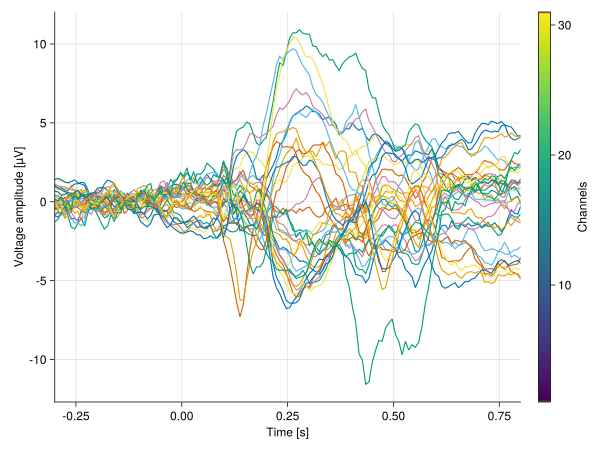

In [122]:
let 
    data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .< 32 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)

    f = Figure()
    ax = f[1, 1] = Axis(f,# xticks = map(x -> round(x, digits = 2) , range(minimum(data.time), stop = maximum(data.time), length = 5)), 
    xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    hidespines!(ax, :t, :r) 
    CairoMakie.xlims!(-0.3,0.8)

    #data  
 
    for i in unique(data[:, :channel])
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected)
    end 

    Colorbar(f[1, 2] , limits = (1, length(unique(data[:, :channel]))), label = "Channels")
    f
    #save("plots/plot2.svg", f)
end

- topoplot instead of colorbar

# 3. Single topoplot

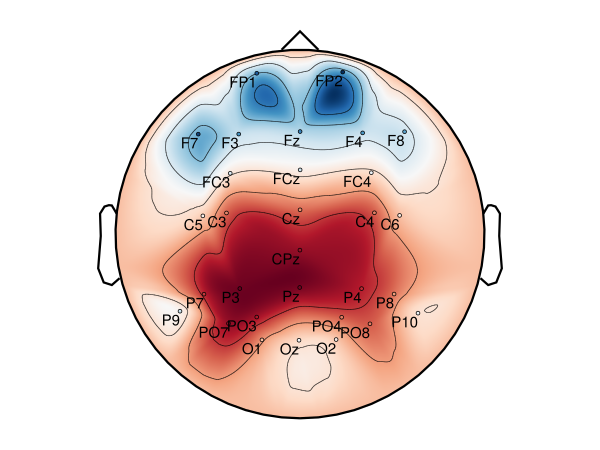

In [564]:
let 

    using CairoMakie
    eeg_topoplot(mean(dat_e[1:30, 100, :], dims=2)[:,1], # averaging all trial of 30 participants on 100th msec
        raw.ch_names[1:30]; 
        positions=pos, # produced  automatically from ch_names
        label_text=true,
        axis=(aspect=DataAspect(),)) # aspect ratio, correlation of height and width
    hidedecorations!(current_axis())
    hidespines!(current_axis())
    current_figure()
    f = current_figure()
    #save("plots/plot3.svg", f)
end


- TopoPlot library should be updated soon -> pull request new unregistered yet version

# 4. Topographic map

In [123]:
let
    # in progress 
    TopoPlots.eeg_topoplot_series(mean(dat_e[1:30, :, :],dims=3)[:,:,1],50; 
    positions=pos,
    label_text=true,
    axis=(aspect=DataAspect(),))

end


# 5. Topoplot array

# 5.0. 


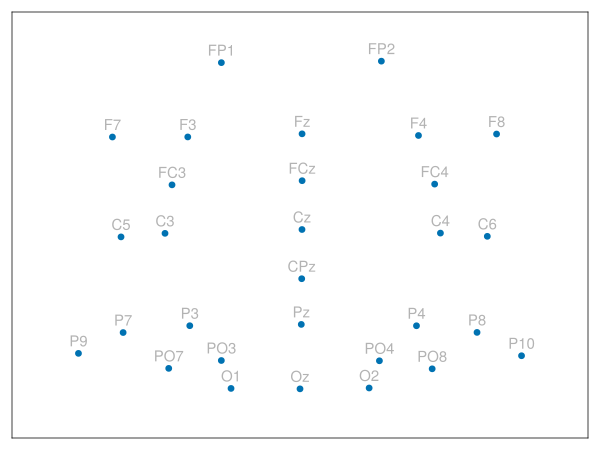

In [577]:
# layout observation
let
    f = Figure()
    ax = Axis(f[1, 1], #yreversed = true,
    xautolimitmargin = (0.15, 0.15),
    yautolimitmargin = (0.15, 0.15)
    )
    hidedecorations!(ax)
    CairoMakie.scatter!(pos)

    text!(pos, text = raw.ch_names[1:30], color = :gray70, offset = (0, 5),
        align = (:center, :bottom))
    f
end

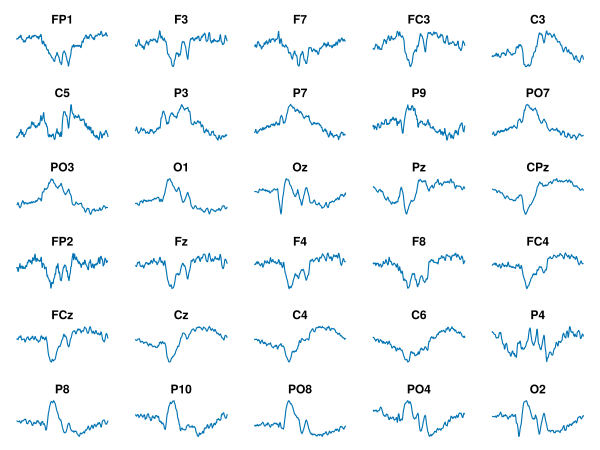

In [360]:
# grid version
let 
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>

        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)


    f = Figure()
    row = 1
    col = 1
    for i in 1:30
        ax = Axis(f[row, col], title = raw.ch_names[i]) # attribte for position 
        col = col + 1
        if i % 5 .== 0
            col = 1 
            row = row + 1 
        end
        hidespines!(ax) 
        hidedecorations!(ax)
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected)
    end
    f
    #save("plots/plot5.svg", f)
end

# 5.1

In [191]:
# important functions for the main plot
function del_empt2(coord)
    # searching for unsued coordinates

    tmp = Array(minimum(coord):maximum(coord))
    unused = []
    for i in tmp
        if !(i in coord)
            append!(unused, i)
        end
    end
    
    # creation of new coordinates without unused ones
    newcoord = []
    for i in coord
        q = 0
        for j in unused  
            if i > j
                q = findall(x->x==j, unused)[1]
            end
        end
        append!(newcoord, i - q)
    end 
    newcoord
end

function del_empt(pos)
    x, y = [], []

    for i in pos
        append!(x, i[1])
        append!(y, i[2])
    end
    x = round.(x; digits=2)
    y = Integer.(round.((y .- mean(y))  * 20)) * -1
    x = Integer.(round.((x .- mean(x))  * 20))

    newx = del_empt2(x)
    newy = del_empt2(y)

    # twiching the lateral electodes' positons
    ma = findall(xx->xx==maximum(newx), newx)[1]
    mi = findall(xx->xx==minimum(newx), newx)[1]
    newx[mi] = newx[mi] + 1
    newx[ma] = newx[ma] - 1
    # return
    newx, newy
end

del_empt (generic function with 1 method)

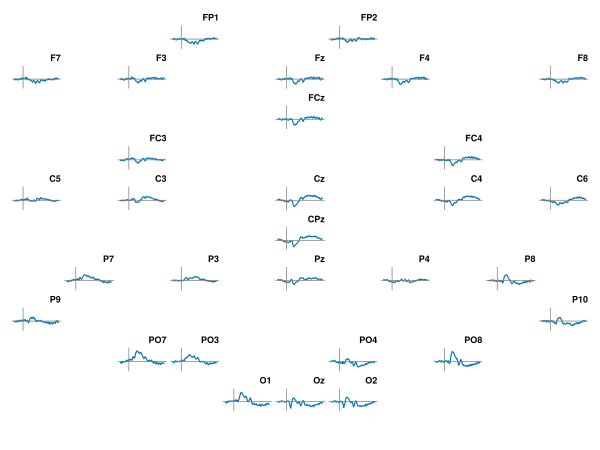

In [227]:
# the main plot
let 
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)

    f = Figure()
    gl = f[1, 1] = GridLayout()

    x = []
    y = []
    x, y = del_empt(pos)

    for i in 1:30
        col = x[i]
        row = y[i]
        #ax = Axis(f, title = raw.ch_names[i], bbox = BBox(100+col, 300, 100, 500),
        ax = Axis(gl[row, col], title = raw.ch_names[i], # bbox = BBox(100, 300, 100, 500),
        titlealign = :right, titlesize = 12) # attribte for position 
        #println(raw.ch_names[i], " ",  row, " ", col)
        hidespines!(ax) 
        hidedecorations!(ax)
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected)
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        Makie.ylims!(low = -10, high = 14)
        #
    end
    Makie.colgap!(gl, 5)
    Makie.rowgap!(gl, 5)
    f
    #save("plots/plot5.svg", f)
end


- allign coordinates

# 5.2

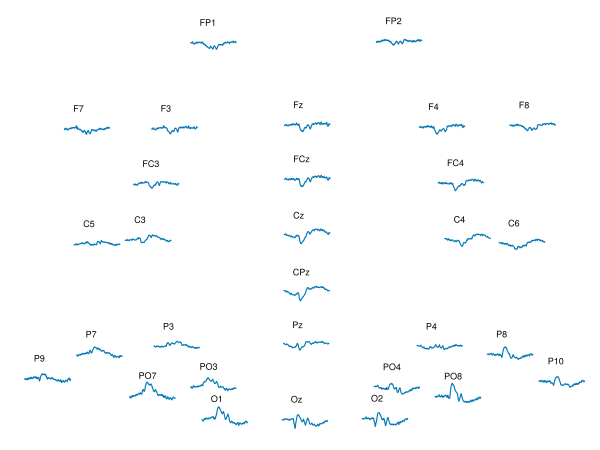

In [145]:
begin
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)
        
    
    fig = Figure()
    ax = Axis(fig[1, 1])

    i = 1
    Makie.xlims!(low = 20, high = 170)
    Makie.ylims!(low = 30, high = 200)
    
    xs = 0:0.01:10
    ys = 0.5 .* sin.(xs)

    xscale = 8
    yscale = 0.5
    
    for i in 1:30
        xmove = pos[i][1] * 200
        ymove =  pos[i][2] * 200 
        #println(raw.ch_names[i], " ", xmove, " ", ymove, " ")
        m4x4 = Makie.Mat4f(xscale, 0, 0, 0,
                        0, yscale, 0, 0,
                        0, 0, 1, 0,
                        xmove, ymove , 0, 1)
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected, model = m4x4, color = "#0077b6")
        text!(xmove, ymove + 6, text = raw.ch_names[i], 
        align = (:left, :bottom), color = :black,
        textsize = 12)
        #hlines!(xmove, color = :black, linewidth = 1, model = m4x4)
        vlines!(0,  xmin = minimum(tmp.estimate_bsln_corrected),
        xmax = maximum(tmp.estimate_bsln_corrected),  color = :red, linewidth = 1)
    end

    hidespines!(ax) 
    hidedecorations!(ax)
    fig
    #save("plots/plot5.svg", fig)
end

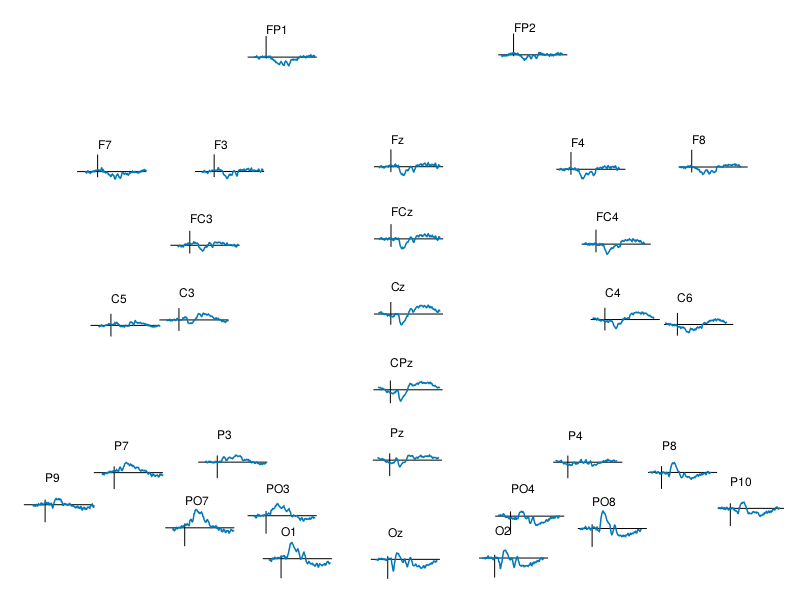

In [44]:
begin
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)
        
    
    fig = Figure()
    ax = Axis(fig[1, 1])

    Makie.xlims!(low = 20, high = 170)
    Makie.ylims!(low = 30, high = 200)
    

    xscale = 8
    yscale = 0.5
    
    for i in 1:30
        xmove = pos[i][1] * 200
        ymove =  pos[i][2] * 200 
        #println(raw.ch_names[i], " ", xmove, " ", ymove, " ")
        m4x4 = Makie.Mat4f(xscale, 0, 0, 0,
                        0, yscale, 0, 0,
                        0, 0, 1, 0,
                        xmove, ymove , 0, 1)
        tmp = data[data[:, :channel] .== i, :]
        a = pos[i][1] 
        a = (a + (a - 0.4660183)* 0.35)  
        b = a + 0.09 
        hlines!(ymove, xmin = a, xmax = b, 
         color = :black, linewidth = 1)

        a = pos[i][2] 
        a = a - (1 - a)/3.2* 0.7 
        #a = a - (0.96 - a)/3.2* 0.7
        b = a + 0.04 
        vlines!(xmove, ymin = a, ymax = b, color = :black, linewidth = 1)

        lines!(tmp.time, tmp.estimate_bsln_corrected, model = m4x4, color = "#0077b6")
        text!(xmove, ymove + 6, text = raw.ch_names[i], 
        align = (:left, :bottom), color = :black,
        textsize = 12)
    
        #println(raw.ch_names[i], " ", pos[i][2] , " ",  a )
    end

    hidespines!(ax) 
    hidedecorations!(ax)
    fig
    #save("plots/plot5.svg", fig)
end

- coordinate lines to indicate where is zero for time ad voltage - vline is badly alligned

# 6. ERP image

In [212]:
let
    #f = Figure()
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])   # ix - trials sorted by time of maximum spike
                                                                        # sortperm() computes a permutation of the array's indices that puts the array into sorted order:
    ix = ix[2000:6000]
    f, ax, hm = CairoMakie.heatmap((dat_e[28,:,ix]), colormap=Reverse("RdBu"), colorrange = (-40, 40))
    @show hm
    ax = current_axis()
    ax.xlabel = "Time [sec]"
    ax.ylabel = "Sorted trials"

    CairoMakie.Colorbar(f[:, end+1], hm, label = "Voltage [µV]") 
    hidespines!(ax, :t, :r) 
    f
    #save("plots/plot6.svg", f)
end

hm = Heatmap{Tuple{Vector{Float32}, Vector{Float32}, Matrix{Float32}}}


MethodError: MethodError: no method matching to_color(::MakieCore.Automatic)
Closest candidates are:
  to_color(!Matched::Number) at ~/.julia/packages/Makie/bwZTV/src/conversions.jl:763
  to_color(!Matched::Colorant) at ~/.julia/packages/Makie/bwZTV/src/conversions.jl:764
  to_color(!Matched::Makie.AbstractPattern) at ~/.julia/packages/Makie/bwZTV/src/conversions.jl:769
  ...

- erp line plot under the ERP image
- add smoothing
- select 2000-6000 trials after sorting 
- current time vector is dummy

# 7.Parallel coordinates

In [186]:
findall(raw.ch_names.=="PO8")
#show(stdout, raw.ch_names)  

1-element Vector{Int64}:
 28

## version 1.1

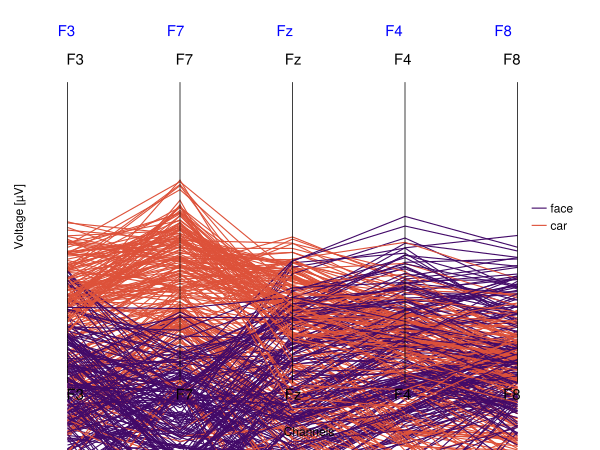

In [1057]:
let
    channels = [2, 3, 17, 18, 19]

    res = effects(Dict(:category=>["face", "car"], :condition=>["intact"]), mres)
    data = @pipe res |> 
        filter(x -> x.channel in channels, _) |>
        select(_, Not([:basisname, :condition])) 

    n = length(channels) # number of axis
    k = 20
    limits = []

    # axes
    f = Figure()
    width = 600;    height = 400
    offset = 90;   center = 300

    for i in 1:n
        x = (i - 1) / (n - 1) * width
        if i == 1
            switch = true
        else
            switch = false
        end
        Makie.LineAxis(f.scene,  limits = (2, -2), # maybe consider as unique axis????
            spinecolor = :black, labelfont = "Arial", 
            ticklabelfont = "Arial", spinevisible = true,  ticklabelsvisible = switch, 
            minorticks = IntervalsBetween(2),  tickcolor = :red, 
            endpoints = Point2f[(offset + x, offset), (offset + x, offset + height)],
            ticklabelalign = (:right, :center), labelvisible = false)
    end

    for j in unique(data.time) 
        tmp1 = filter(x -> (x.time == j),  data) #1 timepoint, 10 rows (2 conditions, 5 channels) 
        for i in ["face", "car"]
            tmp2 = filter(x -> (x.category == i),  tmp1)
            values = map(1:n, tmp2.yhat) do q, d # axes, data
                x = (q - 1) / (n - 1) * width
                Point2f(offset + x, d * 50 + offset) ## why doesn't work??
                    end
            if i .== "face"
                lines!(f.scene, values; color = cgrad(:inferno, 6, categorical = true)[2])
            else  
                lines!(f.scene, values; color = cgrad(:inferno, 6, categorical = true)[4])
            end 
        end
    end 
    ax = f[1, 1] = Axis(f.scene)
    lines!(ax, 1, 1, 1, label = "face", color = cgrad(:inferno, 6, categorical = true)[2])
    lines!(ax, 1, 1, 1, label = "car", color = cgrad(:inferno, 6, categorical = true)[4])
    axislegend(ax, position = :rc, framevisible = false)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 

    ax.xlabel = "Channels";    ax.ylabel = "Voltage [µV]"
    x = Array(10:90:380)
    y = fill(105, 5)

    
    ch = raw.ch_names[channels] #["Ch2", "Ch3", "Ch17", "Ch18", "Ch19"]

    ax = Axis(f[1, 1])
    text!(x, y, text = ch, align = (:center, :center), 
        offset = (0, 0), 
        color = :blue)

    #Makie.scatter!(10:95:390, fill(5, 5))
    text!(x, fill(5, 5),  text = ch)
    text!(x, fill(95, 5), text = ch)
    #println(string.(round.(l_low, digits=2)))
    Makie.xlims!(low = -20, high = 440)
    Makie.ylims!(low = 0, high = 110)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 

    f 
end

## version 1.2

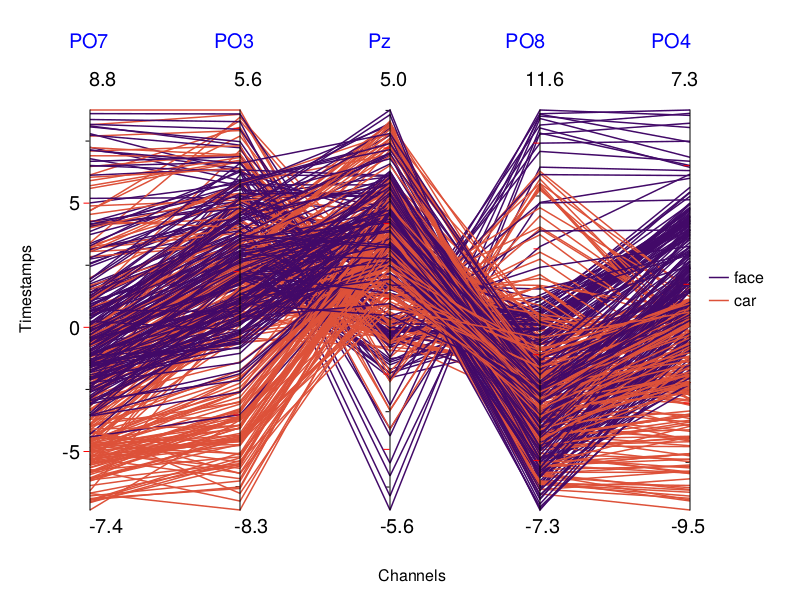

In [51]:
# plot itself
let
    channels = [10, 11, 14, 28, 29] #[2, 3, 17, 18, 19] 

    res = effects(Dict(:category=>["face", "car"], :condition=>["intact"]), mres)
    data = @pipe res |> 
        filter(x -> x.channel in channels, _) |>
        select(_, Not([:basisname, :condition])) 

    n = length(channels) # number of axis
    k = 20

    # axes
    f = Figure()
    width = 600;   height = 400 ;   offset = 90;   
    limits = [] ; l_low = [] ; l_up = []
    
    for i in channels
        tmp = filter(x -> (x.channel == i),  data) 
        w = extrema.([tmp.yhat])
        append!(limits, w)
        append!(l_up, w[1][2])
        append!(l_low, w[1][1])

    end
    println(limits)

    for i in 1:n
        x = (i - 1) / (n - 1) * width
        if i == 1
            switch = true
        else
            switch = false
        end
        Makie.LineAxis(f.scene,  limits = limits[i], # maybe consider as unique axis????
            spinecolor = :black, labelfont = "Arial", 
            ticklabelfont = "Arial", spinevisible = true,  ticklabelsvisible = switch, 
            minorticks = IntervalsBetween(2),  tickcolor = :red, 
            endpoints = Point2f[(offset + x, offset), (offset + x, offset + height)],
            ticklabelalign = (:right, :center), labelvisible = false)
    end

    for j in unique(data.time) 
        tmp1 = filter(x -> (x.time == j),  data) #1 timepoint, 10 rows (2 conditions, 5 channels) 
        for i in ["face", "car"]
            tmp2 = filter(x -> (x.category == i),  tmp1)
            values = map(1:n, tmp2.yhat, limits) do q, d, l # axes, data
                x = (q - 1) / (n - 1) * width
                Point2f(offset + x, (d - l[1]) ./ (l[2] - l[1]) * height + offset) 
                
                    end
            if i .== "face"
                lines!(f.scene, values; color = cgrad(:inferno, 6, categorical = true)[2])
            else  
                lines!(f.scene, values; color = cgrad(:inferno, 6, categorical = true)[4])
            end 
        end
    end 
    ax = f[1, 1] = Axis(f.scene)
    lines!(ax, 1, 1, 1, label = "face", color = cgrad(:inferno, 6, categorical = true)[2])
    lines!(ax, 1, 1, 1, label = "car", color = cgrad(:inferno, 6, categorical = true)[4])
    axislegend(ax, position = :rc, framevisible = false)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 

    ax.xlabel = "Channels";    ax.ylabel = "Timestamps"
    x = Array(10:90:380)
    y = fill(105, 5)

    
    ch = raw.ch_names[channels] 

    ax = Axis(f[1, 1])
    text!(x, y, text = ch, align = (:center, :center), 
        offset = (0, 0), 
        color = :blue)
        
    text!(x, fill(5, 5),  text = string.(round.(l_low, digits=1)))
    text!(x, fill(95, 5),  text = string.(round.(l_up, digits=1)))
    #println(string.(round.(l_low, digits=2)))
    Makie.xlims!(low = -20, high = 440)
    Makie.ylims!(low = 0, high = 110)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 
   
    f 
 
   
end

- two versions with same and different min/max
- crowdiness: 1) transperansy 2) averaging across subjects?
- issue on makie

## version 2

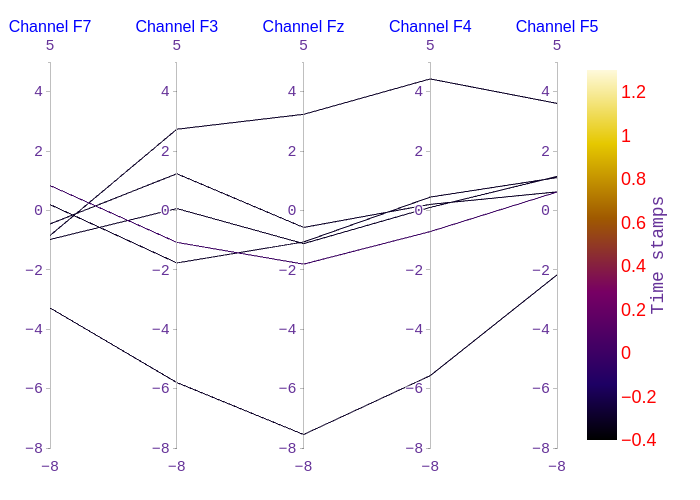

In [770]:
let
    using PlotlyJS, DataFrames

    row = [3, 2, 17, 18, 19]
    timerow = [-0.3, 0.0046875, 0.3015625, 0.60625, 0.903125, 1.2]
    res = effects(Dict(:category=>["face"], :condition=>["intact"]), mres)
    df = @pipe res |> 
        filter(x -> x.channel in row, _) |>
        filter(x -> x.time in timerow, _) |>
        @transform(_, :time = string.(:time)) |>
        select(_, Not([:basisname, :condition])) 
   #show(stdout, unique(df.time))
   #show(stdout, df)
   #df
   

    f = parcoords(; 
        line = attr(color = df.time,  colorscale = "Electric", 
                 colorbar = attr(xpad = 20, title = (text = "Time stamps", size = 12, side = "right"), tickfont = (color = :red, family = "Arial")),
                showscale = true, 
                cmin = -0.4, outlinewidth = 12,
                cmax = 1.3 ),  
        dimensions = [
            attr(range = [-8,5], 
                label = "Channel F7", values = filter(tmp -> (tmp.channel == 3),  df).yhat),
            attr(range = [-8,5],
                label = "Channel F3", values = filter(tmp -> (tmp.channel == 2),  df).yhat),
            attr(range = [-8,5],
                label = "Channel Fz", values = filter(tmp -> (tmp.channel == 17),  df).yhat),
            attr(range = [-8,5],
                label = "Channel F4", values = filter(tmp -> (tmp.channel == 18),  df).yhat),
            attr(range = [-8,5],
                label = "Channel F5", values = filter(tmp -> (tmp.channel == 19),  df).yhat)
            ], 
            labelfont = (color = :blue, size = 16, family = "Arial")            
            ); 

    myplot = PlotlyJS.plot(f, 
    Layout(       
        #xaxis_title="X Axis Title",
        yaxis=attr(title = (text = "Y Axis Title")),
        #legend_title="Legend Title",
        font=attr(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    ))
    myplot
    #unique(df.time)
    #save("plots/plot7.svg", myplot)

end

In [514]:
row = [3, 2, 17, 18, 19]
res = effects(Dict(:category=>["face","car"], :condition=>["intact"]), mres)
data = @pipe res |> 
    filter(x -> x.channel in row, _) |>
    select(_, Not([:basisname, :condition])) 
# get every 5th  value
size(data.time)

(1930,)

# 8. Channel image

In [160]:
let 
    using CairoMakie
    #f = Figure()
     
    ix = range(-0.3, 1.2, length = size(dat_e, 2))
    iz = mean(dat_e, dims=3)[1:30, :, 1]'
    
  

    f, ax, hm = CairoMakie.heatmap(ix, 1:30,  iz, # how to reshape this into matrix???
       colormap="cork") # single trial
    ax = current_axis()
    ax.xlabel = "Time [sec]"
    ax.ylabel = "Channels"
    ax.yticks = 1:30
    #ax.ytickformat =  xs -> collect(keys(d))

    ax.ytickformat = xs -> raw.ch_names[Int.(xs)]
    Colorbar(f[1, 2], hm,  label = "Voltage [µV]") 
    current_figure()
    #save("plots/plot8.svg", f)
end 

MethodError: MethodError: no method matching to_color(::MakieCore.Automatic)
Closest candidates are:
  to_color(!Matched::Number) at ~/.julia/packages/Makie/bwZTV/src/conversions.jl:763
  to_color(!Matched::Colorant) at ~/.julia/packages/Makie/bwZTV/src/conversions.jl:764
  to_color(!Matched::Makie.AbstractPattern) at ~/.julia/packages/Makie/bwZTV/src/conversions.jl:769
  ...

In [161]:
let 
    #f = Figure()
     
    ix = range(-0.3, 1.2, length = size(dat_e, 2))
    iz = mean(dat_e, dims=3)[1:30, :, 1]'
    
  
    d = Dict()
    for i in 1:30
        get!(d, raw.ch_names[i], iz[1*i:193*i])
    end
    d = sort(d)
    val = values(d)

    f, ax, hm = CairoMakie.heatmap(ix, 1:30,  collect(val), # how to reshape this into matrix???
       colormap="cork") # single trial
    ax = current_axis()
    ax.xlabel = "Time [sec]"
    ax.ylabel = "Channels"
    ax.yticks = 1:30
    ax.ytickformat =  xs -> collect(keys(d))

    #ax.ytickformat = xs -> raw.ch_names[Int.(xs)]
    Colorbar(f[1, 2], hm,  label = "Voltage [µV]") 
    current_figure()
    #save("plots/plot8.svg", f)
end 

UndefVarError: UndefVarError: heatmap not defined

In [1067]:
#sort(raw.ch_names)
iz = mean(dat_e, dims=3)[1:30, :, 1]'
d = Dict()
for i in 1:30
    get!(d, raw.ch_names[i], iz[1*i:193*i])
end
d = sort(d)
f = [collect(values(d))]
t = []
for i in f
    t
end 

t
#k = keys(d)

#reshape(f, 30, 193)

#iz[1:193]

Any[]

- arrangement of channels should be specified - alphabetical sort? xcoordinates?
- smoothing function could help to incease a resolution

# Data

In [ ]:
let 
    #first(results_onesubject[:, !1], 5)
    #unique(results_onesubject[:, 2])
    data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .== 18) |>
        @transform(_, :channel = string.(:channel)) 
    data = filter(x -> x.coefname == "category: face" || x.coefname == "category: scrambled" , 
    data) 

    data
end